# Building Vision Transformer From Scratch For Image Classification
In this notebook, we are going to implement the **Vision Transformer (ViT)** from scratch using PyTorch, and use the model to perform image classification for different breeds of dogs. 

The reserach paper, ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929), introduced a Vision Transformer into computer vision, delivering state-of-the-art performance without using convolution networks. The idea is motivated from the widely acclaimed Transformer architecture in the domain of natural language processing (NLP). Our objective in replicating the paper is to grasp the essential concepts in the Vision Transformer. 

- **Task 1**: Develop Vision Transformer from scratch
- **Task 2**: Apply image classification to identify different dog breeds

We employ one NVIDIA RTX A6000 to train the notebook, and the training time is within 20 minutes. 

# 0. Setup Environment
The code is developed with Python 3.10 (or newer) version, PyTorch 2.1.0, torchvision 0.16
Please install the required package to continue. 

In [1]:
# Installed the requied packages.
# !pip install -r requirements.txt
! pip install torch torchvision torchinfo matplotlib numpy Pillow Requests tqdm 


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
!python --version

Python 3.10.12


In [3]:
# If PyTorch is installed.
try:
    import torch
    import torchvision
    print("PyTorch version: ", torch.__version__)
    print("torchvision version:: ", torchvision.__version__)
    assert int(torch.__version__.split(".")[0]) >= 2, "PyTorch version should be 2.0+"

# If PyTorch is not installed yet
except:
    print("PyTorch not found. Install PyTorch...")
    !pip3 install torch torchvision torchaudio

    import torch
    import torchvision
    print("PyTorch version: ", torch.__version__)
    print("torchvision version:: ", torchvision.__version__)    

PyTorch version:  2.1.0+cu118
torchvision version::  0.16.0+cu118


In [4]:
### Assign device to GPU
# device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    
device

'cuda'

In [5]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image 
from tqdm import tqdm

In [6]:
from torch import nn

try: 
    from torchinfo import summary
except:
    !pip install torchinfo
    from torchinfo import summary
    
from torchvision.transforms import v2

In [7]:
### Global VARIABLES ###
SEED_NO = 100

# Hyper-parameters configs
NUM_EPOCH = 15

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
IMG_SIZE = 224
H = IMG_SIZE
W = IMG_SIZE
PATCH_SIZE = 16
CHANNELS = 3

print(f"NUM_WORKERS= {NUM_WORKERS}")

NUM_WORKERS= 64


# 1. Get Data
## 1.1 Stanford Dogs dataset
We will use the **Stanford Dogs dataset**. You can download the dataset from either one of the two sites.
- [http://vision.stanford.edu/aditya86/ImageNetDogs/](http://vision.stanford.edu/aditya86/ImageNetDogs/)
- [https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset/](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset/)

You could use the *wget* command to download the tar files and then decompress the files. 
Please follow the following directory structure. After decompress tar files, please copy your classification target images under the folder **./datasets/StanfordDogsDataset/myImages**

In [8]:
###### Uncomment to download the dataset and decompress files
# !wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
# !wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
# !tar -xvf annotation.tar
# !tar -xvf images.tar

In [9]:
###### Directory Structure
# ${ROOT}  
# |-- assets (assets for the notebook)
# |-- images (images for testing
# |-- datasets 
# |   |-- StanfordDogsDataset
# |   |   |-- Annotation
# |   |   |   |-- n02085620-Chihuahua
# |   |   |   |-- ...
# |   |   |   |-- ...
# |   |   |-- Images
# |   |   |   |-- n02085620-Chihuahua
# |   |   |   |-- ...
# |   |   |   |-- ...
# |   |   |-- myImages
# |   |   |   |-- your choice of dog 1 for image classification
# |   |   |   |-- your choice of dog 2 for image classification
# |   |   |   |-- your choice of dog 3 for image classification
# |   |   |   |-- ...


## 1.2. Load Dataset
- First, the image files need to be converted to PyTorch tensors (using compose & transform).
- Then, we can use PyTorch ImageFolder to load the dataset. 

In [10]:
working_dir = os.getcwd()
## If you would like to train the whole dataset
# dataset_dir = working_dir + "/datasets/StanfordDogsDataset/Images"

## Train part of the Stanford Dogs dataset
dataset_dir = working_dir   + "/datasets/StanfordDogsDataset/myImages"

print(f"Current working directory: \t {working_dir}")
print(f"Dataset directory: \t\t {dataset_dir}")

Current working directory: 	 /workspace/vit_pet
Dataset directory: 		 /workspace/vit_pet/datasets/StanfordDogsDataset/myImages


In [11]:
# torchvision.transforms.v2 Need torchvision version >= 0.15
transform_original = v2.Compose([
        v2.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
])
transform_original

Compose(
      Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToImage()
      ToDtype(scale=True)
)

In [12]:
# Stanford Dogs Dataset
dataset_original = torchvision.datasets.ImageFolder(dataset_dir, transform=transform_original)
print("The original content of Stanford Dogs Dataset") 
print(f"Number of dog images: {len(dataset_original)}")
print(f"Number of dog breeds: {len(dataset_original.classes)}")

The original content of Stanford Dogs Dataset
Number of dog images: 521
Number of dog breeds: 3


In [13]:
dataset_original.classes

['n02099601-golden_retriever', 'n02106030-collie', 'n02111889-Samoyed']

## 1.3 Get classes in the dataset
Check the number of dog breeds in the specified dataset. Each dog breed will be our label for the image classification. 

In [14]:
## Get classes in the original dataset

# Rename class name
def renameLabels(label):
    """ 
    Rename class name from 'n02085620-Chihuahua' to 'Chihuahua'
    """
    label = ' '.join(label.split('-')[1:])  # keep only dog breeds
    label = ' '.join(label.split('_'))  # spilit by _ 
    return label.title()


breeds = []
for name in dataset_original.classes: 
    breeds.append(renameLabels(name))

print("Dog breeds:")
print(breeds)

Dog breeds:
['Golden Retriever', 'Collie', 'Samoyed']


## 1.4 Data Augmentation
- For each dog breed, there are only about 100 ~ 200 images in the origianl dataset. To improve the performance of model, we need to create new examples to better train the model. By using PyTorch transform, we create more variations of the original data. Thus, the size of training data become large, and it helps prevent overfitting in the training data. 

- Here, we use the random transform to create a 5X larger dataset than the original dataset.  

In [15]:
# Random rotation
transform2 = v2.Compose([
        v2.RandomHorizontalFlip(p=1), # flip images
        v2.RandomRotation(degrees=(-30,30)),  # from -degree to +degree
        v2.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), 
                             scale=(0.5, 0.9), # lower & upder bounds for the random area of the crop, before resizing.
                             antialias=True),
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),])

# Random perspective and crop
transform3 = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.4, p=1),
        v2.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), 
                             scale=(0.5, 0.8), # lower & upder bounds for the random area of the crop, before resizing. 
                             antialias=True),
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),])

In [16]:
def show1Image(img, img_title, fig_size=(3,3)):
    # Convert format from (C,H,W) to (H,W,C) for matplotlib 
    img = img.permute(1,2,0)
    plt.figure(figsize=fig_size)
    plt.imshow(img)
    plt.title(img_title)
    plt.show()


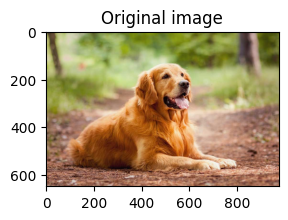

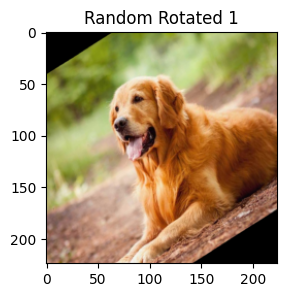

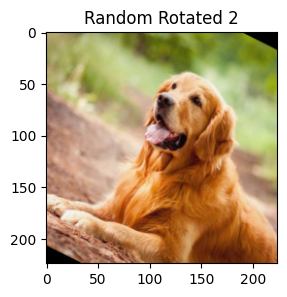

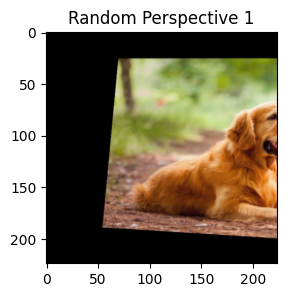

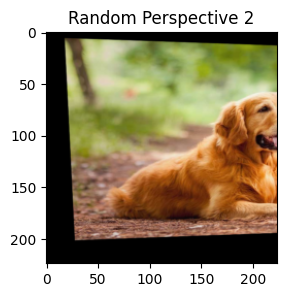

In [17]:
# Examples of data augmentation
img_before = torchvision.io.read_image("images/test_golden_retriever_2.jpeg")
img_after2_list = [transform2(img_before) for _ in range(2)]
img_after3_list = [transform3(img_before) for _ in range(2)]

show1Image(img_before, "Original image")
show1Image(img_after2_list[0], "Random Rotated 1")
show1Image(img_after2_list[1], "Random Rotated 2")
show1Image(img_after3_list[0], "Random Perspective 1")
show1Image(img_after3_list[1], "Random Perspective 2")

- By employing PyTorch transforms, we introduce an additional set of four variations to the original image. Consequently, after data augmentation, the training dataset expands to five times its original size." 

In [18]:
dataset2 = torchvision.datasets.ImageFolder(dataset_dir, transform=transform2)
dataset3 = torchvision.datasets.ImageFolder(dataset_dir, transform=transform2)
dataset4 = torchvision.datasets.ImageFolder(dataset_dir, transform=transform3)
dataset5 = torchvision.datasets.ImageFolder(dataset_dir, transform=transform3)
dataset = torch.utils.data.ConcatDataset([dataset_original, dataset2, dataset3, dataset4, dataset5])
print(f"In the original dataset, number of dog images: {len(dataset_original)}")
print(f"After data augmentation, number of dog images: {len(dataset)}")

In the original dataset, number of dog images: 521
After data augmentation, number of dog images: 2605


## 1.5 Split training, validation, and test dataset
- The dataset will be divided into 3 parts: training, validation, and testing. 

In [19]:
torch.manual_seed(SEED_NO)
split_ratio = [0.7, 0.15, 0.15]
train_data, val_data, test_data = torch.utils.data.random_split(dataset, split_ratio)

In [20]:
print("Size of training data: ", len(train_data))
print("Size of validation data: ", len(val_data))
print("Size of test data: ", len(test_data))

Size of training data:  1824
Size of validation data:  391
Size of test data:  390


## 1.6 Turn image data to PyTorch DataLoader

In [21]:
# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

val_dataloader = torch.utils.data.DataLoader(val_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

test_dataloader = torch.utils.data.DataLoader(test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

In [22]:
print(f"Batch size = {BATCH_SIZE}")
print(f"Training data size:   {len(train_dataloader.dataset)}\t= {len(train_dataloader)} batches.")
print(f"Validation data size: {len(val_dataloader.dataset)}\t= {len(val_dataloader)} batches.")
print(f"Test data size:       {len(test_dataloader.dataset)}\t= {len(test_dataloader)} batches.")

Batch size = 32
Training data size:   1824	= 57 batches.
Validation data size: 391	= 13 batches.
Test data size:       390	= 13 batches.


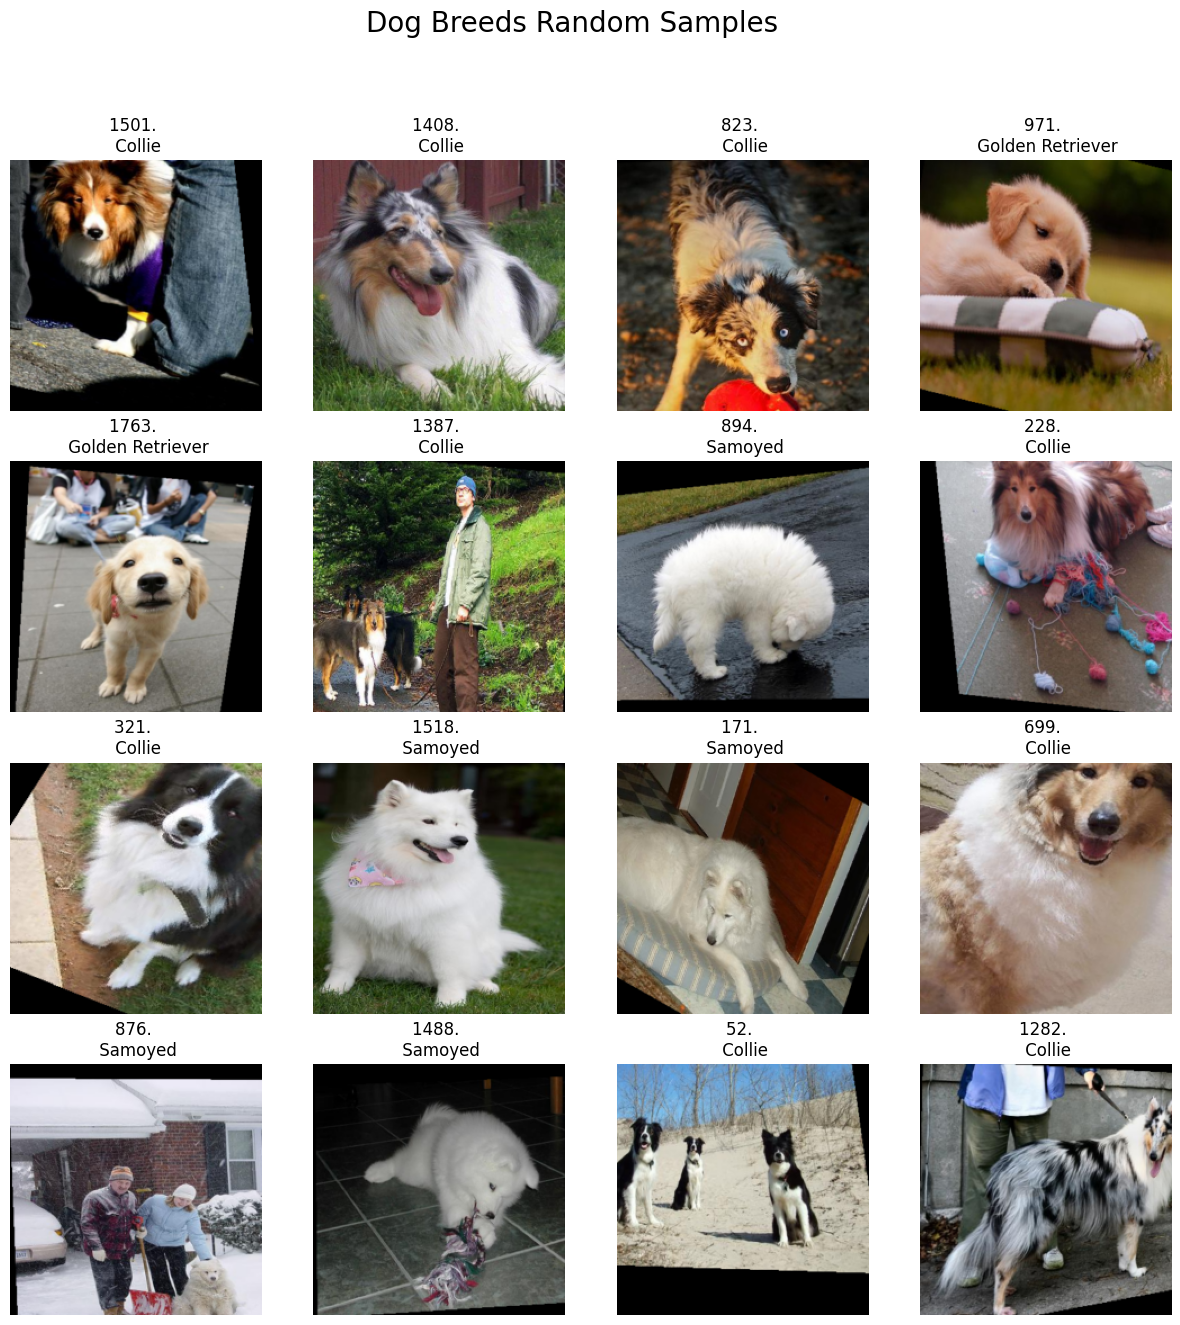

In [23]:
# Plot random images in grids
rows = 4
cols = 4

fig, axs = plt.subplots(rows, cols, figsize=(15,15))
fig.suptitle("Dog Breeds Random Samples", fontsize=20)

random_list = random.sample(range(len(train_data)), (rows * cols))
for i, ax in zip(random_list, axs.flat):
    img_tensor, name_id = train_data[i]
    img = v2.ToPILImage()(img_tensor)
    # breed_name = renameLabels(dataset.classes[name_id])
    breed_name = breeds[name_id]
    ax.axis("off")
    ax.set_title(f"{i}. \n {breed_name}")
    ax.imshow(img)

# plt.tight_layout()
plt.show()

- In this figure, we display random 16 images in the training dataset. 

# 2. Vison Transformer Overview 

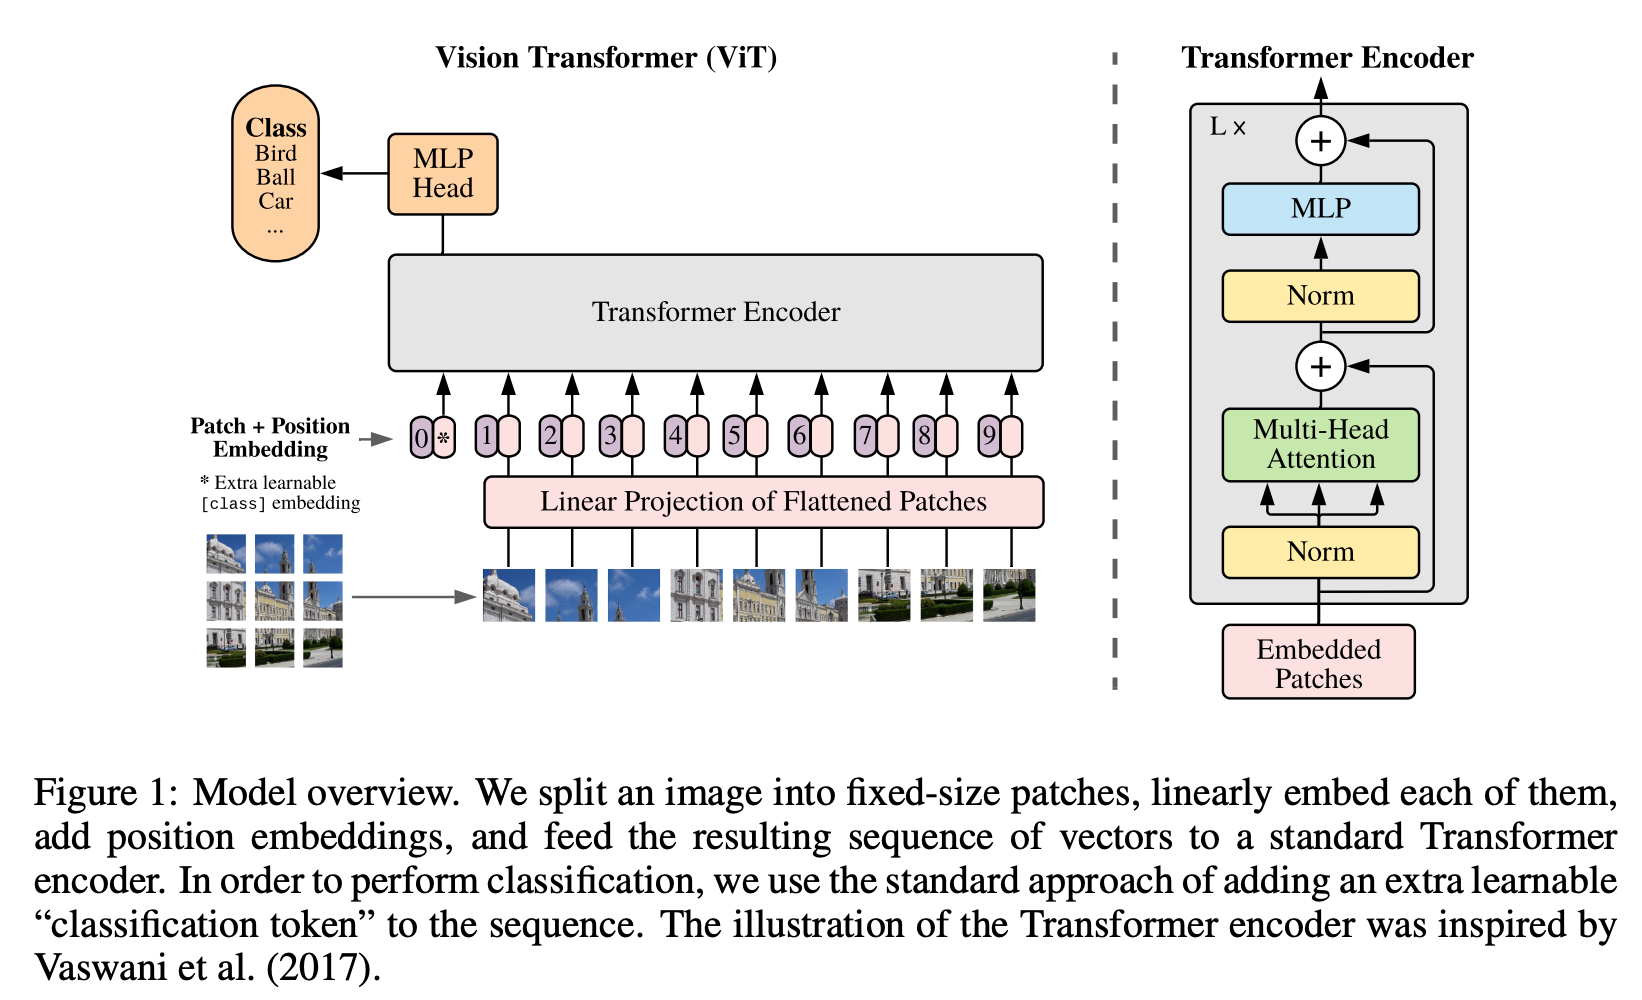

The figure shows the pipeline of the Vision Transformer. A Vision Transformer model will contain the following layers. 
## 2.1 Patch + Position Embedding inputs:
- The input image will divide into a sequence of image patches. The size of each patch is 16 x 16.
- The image patches are flattened to 1D embedding by a trainable linear projection. The ouput of the projection, called patch embeddings, are learnable representation for the Vision Transformer. 
- Concatenate a position number to the 1D embedding. The purpose of the position embedding is to retain the related spatial information of the patch.
-  A class token will be also concatenate to the sequence of embedded patches. The token will be learnable and serve as the label for the image classification task. 

## 2.2 Transformer Encoder
  The encoder contain 2 main blocks,
-  Multi-Head Self-Attention (MSA)
    - The attention mechanism is the crucial part in the Transformer model, which is introduced by the paper ["Attention Is All You Need
"](https://arxiv.org/abs/1706.03762)
-  Multi-Layer Perceptron (MLP)
    - The Multi-Layer Perceptron is a fully-connected feedforward networks.
- The input of both blocks will be first processed by the Layer Normalization (Norm). It is used to regularize a neural network to prevent overfitting.
- The output of both blocks will have residual connections. Residual connections overcome vanishing gradients, and improve the stability of a deep neural network. It is proposed by the paper ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385v1).
    
## 2.3 MLP Head
   - This component serves as the output layer. The class output is generated from the learned embeddings. In our context of image classification, it can be referred to as the *"classifier head"*. The structure of MLP Head is also a fully-connected feedforward network.

# 3. Patch Embedding

The most important idea of the ViT paper is to divide the input image into patches. Then, each patch is converted to embeddings as input sequences for the sequence-to-sequence model, which is transformer model.  

## 3.1 Create image patches

In [24]:
def getNumsOfPatches(height, width, patch_size):
    return int((height * width) / (patch_size**2))

nums_patches = getNumsOfPatches(H, W, PATCH_SIZE)
print(f"Number of patches in the image ({H} * {W}) = {nums_patches}")

Number of patches in the image (224 * 224) = 196


In [25]:
# the dimension for the input embedding & the ouput embedding
embedding_input_dim = (H, W, CHANNELS)
embedding_output_dim = (nums_patches, (PATCH_SIZE **2) * CHANNELS)
print("Dimension of the input embedding: \t", embedding_input_dim)
print("Dimension of the output embedding: \t", embedding_output_dim)

Dimension of the input embedding: 	 (224, 224, 3)
Dimension of the output embedding: 	 (196, 768)


### Example of a patches-divided image 

An sample input image from our augmented dataset


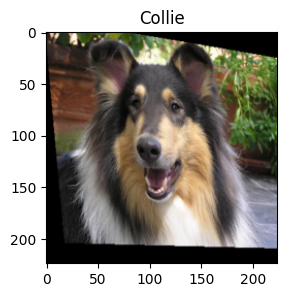

In [26]:
# random_id = random.randint(0, len(train_data))
# sample, sample_id = train_data[random_id]

# Get a batch of images
sample_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
sample, sample_id = sample_batch[0], label_batch[0]
sample_name = breeds[sample_id]

print("An sample input image from our augmented dataset")
show1Image(sample, sample_name)

Divide the input image into patches. Each image patch size is 16 x 16.
The dog breed =  Collie


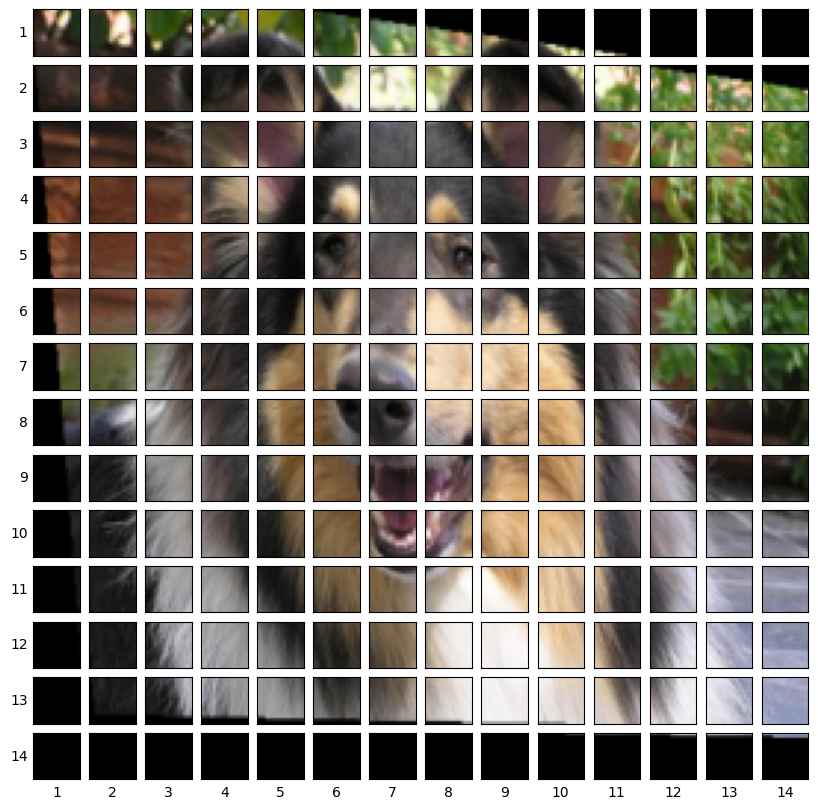

In [27]:
# Draw the patches-divided sample
print("Divide the input image into patches. Each image patch size is 16 x 16.")
print("The dog breed = ", sample_name)
assert IMG_SIZE % PATCH_SIZE == 0, "Image size must be divisible by patch size"
fig, axs = plt.subplots(nrows=IMG_SIZE // PATCH_SIZE,
                        ncols=IMG_SIZE // PATCH_SIZE,
                        figsize=(10, 10),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_h in enumerate(range(0, IMG_SIZE, PATCH_SIZE)): # iterate through height
    for j, patch_w in enumerate(range(0, IMG_SIZE, PATCH_SIZE)): # iterate through width

        # Plot the image (Height, Width, Color Channels)
        sample_permuted = sample.permute(1,2,0) # Convert format from (C,H,W) to (H,W,C) for matplotlib
        img1 = sample_permuted[patch_h: patch_h + PATCH_SIZE, 
                               patch_w: patch_w + PATCH_SIZE, 
                               :]
        axs[i, j].imshow(img1)

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
# fig.suptitle(f"{sample_name} -> Patchified", fontsize=24)
plt.show()

## 3.2 Create PatchEmbedding

### Patch Embedding
- **Input:** 2D image with $H \cdot W \cdot C$
    - $H$ = image height
    - $W$ = image width
    - $C$ = number of image channels

- **Output:** 1D sequence of flattened 2D patches $ N \cdot (P^2 \cdot C)$
    - $P$ stands for the size of patch. Here, we assume both the input image and the patch are squares.
    - $N$ stands for the number of patches in a given image.

For image size of 224 and patch size of 16:
- **Input tensor shape:** $H \cdot W \cdot C = (224, 224, 3)$
- **Output tensor shape:** (number of patches, embedding dimension)= $(N, (P^2 \cdot C)) = (14 * 14, 16*16*3) = (196,  768) $

### Flattening the patch embedding
- After Conv2d, the tensor shape = torch.Size([1, 768, 14, 14]) = [batch_size, embedding_dim, feature_map_rows, feature_map_cols]
- We convert the spatial part of the feature map into 1D. 
    - Flatten (feature_map_rows, feature_map_cols)=(14,14) => (196)  
- Make sure the correct order for the output shape 
    - [batch_size, $P^2 * C$, $N$] -> [batch_size, $N$, $P^2 * C$]
- Note that the class embedding and position embeddings will be implemented in the Vision Transformer (ViT) later. 


In [28]:
class PatchEmbedding(nn.Module):
    """
    Convert image to patches, and turn patched-images into 1D flattern embeddings.
    
    parameters:
    -----------
    channels: int, number of color channels
    image_size: int, image height & width (assume it is a sqaure image)
    patch_size: int, patch height & width (assume it is a sqaure patch)
    embedding_dim: int, the dimension of the learable embedding
    """
    
    def __init__(self, channels=3, image_size=224, patch_size=16, embedding_dim=768):
        super().__init__()
        assert (image_size % patch_size == 0), "Image size should be an integer multiple of patch size."
        
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2 
        
        # Use nn.Conv2d to convert image to patches
        self.divider = nn.Conv2d(in_channels=channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        # Flatten the last two dimension (image_size, image_size) into one dimesion
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        """
        Forward pass.
        parameters:
        -----------
        x : torch.Tensor, shape=(num_samples, channel, image_size, image_size)
        Return: torch.Tensor, shape=(num_samples, num_patches, embedding_dimension)
        """        
        x = self.divider(x)
        x = self.flatten(x)  # (num_samples, embedding_dimension, num_patches)
        x = x.transpose(1,2)   # (num_samples, num_patches, embedding_dimension)

        # [num_samples, P^2 * C, N] -> [num_samples, N, P^2 * C]
        return x

### Test the PatchEmbedding class

In [29]:
# Test the PatchEmbedding class on single image
patched = PatchEmbedding(channels=CHANNELS,
                         image_size=IMG_SIZE,
                         patch_size=PATCH_SIZE,
                         embedding_dim=(PATCH_SIZE * PATCH_SIZE * CHANNELS))

patched

PatchEmbedding(
  (divider): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (flatten): Flatten(start_dim=2, end_dim=3)
)

In [30]:
# Why unsqueeze(0)?
# Add an extra batch dimension on the 0th index
patch_embedded_image = patched(sample.unsqueeze(0))

print(f"Image tensor shape:  \t\t{sample.shape}")
print(f"Input image shape: \t\t{sample.unsqueeze(0).shape} = [num_samples, channels, hight, width]")
print(f"Output patch embedding shape: \t{patch_embedded_image.shape} = [num_samples, number_of_patches, embedding_dimension]")

Image tensor shape:  		torch.Size([3, 224, 224])
Input image shape: 		torch.Size([1, 3, 224, 224]) = [num_samples, channels, hight, width]
Output patch embedding shape: 	torch.Size([1, 196, 768]) = [num_samples, number_of_patches, embedding_dimension]


# 4. Transformer Encoder 
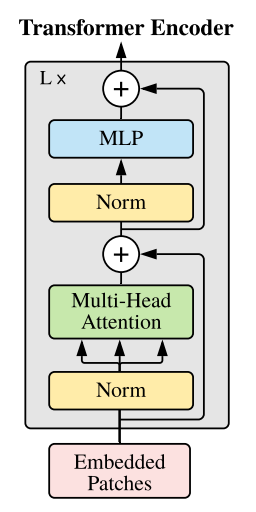

## 4.1 Multi-Head Attention & Norm (Layer Normalization)

In [31]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head Self-Attention Block (MSA) in ViT paper. Layer norm is applied before MSA block. 
    
    parameters:
    -----------
    The values of parameters are referenced from Table 1 in the ViT paper. 
    embedding_dim: Hidden size D
    num_heads: Number of heads in self-attention
    attn_dropout: dropout for training
    """
    def __init__(self, embedding_dim=768,
                 num_heads=12,
                 attn_dropout=0.0):
        super().__init__()
        
        # Norm (Layer Normalization, LN)
        self.norm = nn.LayerNorm(embedding_dim)
        
        # MSA block
        # batch_first=True, then the input and output tensors are provided as (batch, seq, feature)
        self.multihead_attn = nn.MultiheadAttention(embedding_dim, 
                                                    num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    # Forward pass
    # Set need_weights=False to use the optimized scaled_dot_product_attention and achieve the best performance for MSA. 
    def forward(self, x):
        x = self.norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        
        return attn_output
        

## 4.2 MLP & Norm (Layer Normalization)

In [32]:
class MLP(nn.Module):
    """
    Multi-layer Perceptron network
    parameters:
    -----------
    embedding_dim: int, Hidden size D 
    out_dim: int, MLP size from Table 1 in ViT paper
    """
    def __init__(self, embedding_dim: int = 768,
                 out_dim: int = 3072,
                 dropout: float = 0.1):
        super().__init__()
        
        # Apply Norm (Layer Normalization, LN) before MLP
        self.norm = nn.LayerNorm(embedding_dim)
        
        # Multi-layer perceptron (MLP) 
        # "The MLP contains two layers with a GELU non-linearity."
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, out_dim),
            nn.GELU(), 
            nn.Dropout(p=dropout),
            nn.Linear(out_dim, embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    def forward(self, x):
        x = self.norm(x)
        x = self.mlp(x)
        return x
        
    

## 4.3 Transformer Encoder

In [33]:
class TransformerEncoder_x1(nn.Module):
    """
    One Transformer Encoder block
    parameters:
    -----------
    
    """
    def __init__(self,
                 # MSA
                 embedding_dim: int = 768, 
                 num_heads: int = 12,
                 attn_dropout: float = 0,
                 # MLP
                 mlp_out_dim: int = 3072,
                 mlp_dropout: float = 0.1):
        
        super().__init__()
        
        # 1. MSA block: Norm + Multi-Head Attention
        self.msa = MultiHeadAttention(embedding_dim=embedding_dim,
                                      num_heads=num_heads,
                                      attn_dropout=attn_dropout)
        # 2. MLP block: norm + MLP
        self.mlp = MLP(embedding_dim=embedding_dim,
                       out_dim=mlp_out_dim,
                       dropout=mlp_dropout)
        
    def forward(self, x):
        # 3. Residual connection for MSA block
        x = x + self.msa(x)
        
        # 4. Residual connection for MLP block
        x = x + self.mlp(x)
        
        return x

# 5. Vision Transformer (ViT)

In [34]:
class ViT(nn.Module):
    """
    Vision Transformer 
    
    parameters:
    -----------
    
    """
    def __init__(self, 
                 # PatchEmbedding
                 channels: int = 3, 
                 image_size: int= 224, 
                 patch_size: int = 16, 
                 embedding_dim: int=768,
                 # TransformerEncoder
                 encoder_layers: int = 12, 
                 # TransformerEncoder -- MSA                 
                 num_heads: int = 12,
                 attn_dropout: float = 0,                                  
                 # TransformerEncoder -- MLP
                 mlp_out_dim: int = 3072,
                 mlp_dropout: float = 0.1,
                 # Output
                 num_classes: int=1000,
                 embedding_dropout: float = 0.1):
                 
        super().__init__()
        
        # Check image size is divisble 
        assert (image_size % patch_size == 0), "Image size should be an integer multiple of patch size."
        
        # Find number of patches
        self.num_patches = (int(image_size // patch_size)) ** 2
        
        # Add learnable class embedding
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # Add position embeddin
        self.position_embedding = nn.Parameter(torch.randn(1, 1 + self.num_patches, embedding_dim),
                                               requires_grad=True)
        
        # Dropout for embedding
        self.embedding_dropout = nn.Dropout(embedding_dropout)
        
        # PatchEmbedding Block
        self.PatchEmbedding = PatchEmbedding(channels, image_size, patch_size, embedding_dim)
        
        # Transformer Encoder Block
        # Cascade L x TransformerEncoder_x1 
        self.TransformerEncoder_xL = nn.Sequential(
            *[TransformerEncoder_x1(# MSA
                                    embedding_dim=embedding_dim, 
                                    num_heads=num_heads,
                                    attn_dropout=attn_dropout,
                                    # MLP
                                    mlp_out_dim=mlp_out_dim,
                                    mlp_dropout=mlp_dropout) for _ in range(encoder_layers)])
        
        # MLP  classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, num_classes))
        
    def forward(self, x):
        # input shape = [batch_size, channel, image_size, image_size]
        batch_size = x.shape[0]
        
        #  class_token
        class_token = self.class_embedding.expand(batch_size, -1, -1) 
        
        x = self.PatchEmbedding(x)
        
        # Concatenates class_token (Equation 1)
        x = torch.cat((class_token, x), dim=1)
        
        # Add position embedding
        x = x + self.position_embedding 
        
        # Embedding dropout
        x = self.embedding_dropout(x)
        
        # Pass embedding to TransformerEncoder
        x = self.TransformerEncoder_xL(x)
        
        # Put 0 index logit (Equation 4)
        x = self.classifier(x[:, 0])
        
        return x
        

In [35]:
# Create instance of ViT
print(f"Total number of breeds: {len(breeds)}")
vit = ViT(num_classes=len(breeds))

Total number of breeds: 3


In [36]:
# Use torchinfo to give a summary of the ViT model
# https://github.com/TylerYep/torchinfo

# Parameters:
# input_size = (color channels, iamge_height, image_width) 
# batch_size = number of samples in a batch
# col_names = ["input_size", "output_size", "num_params", "params_percent", "kernel_size", "mult_adds", "trainable"]
# col_width: width of each column
# row_settings: support ["ascii_only", "depth", "var_names"]

summary(model = vit,
        input_size = (BATCH_SIZE, CHANNELS, IMG_SIZE, IMG_SIZE), 
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (PatchEmbedding)                            [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (divider)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (TransformerEncoder_xL)                         [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoder_x1 (0)                             [32, 197, 768]       [32, 197, 768]

# 6. Training the Vission Transformer (ViT)
## 6.1 Train and Evaluate functions

In [37]:
# Train 1 epoch
def train_1Epoch(device: torch.device,
                 model: nn.Module,
                 dataloader: torch.utils.data.DataLoader,
                 loss_fn: nn.Module,
                 optimizer: nn.Module):
    """
    Train a model in an epoch.
    dataloader: train_dataloader
    Returns:
    (epoch_loss, epoch_accuracy): tuple of float type
    """
    # Setup model to training mode
    model.train()  # training mode
    phase = "Train"
    running_loss, running_correct = 0.0, 0
    completed_samples = 0
    
    # Load dataloader, and traverse each batch
    for batch_id, data in enumerate(dataloader):
        X = data[0].to(device)
        y = data[1].to(device)  # ground truth label
        
        optimizer.zero_grad()  # zero the parameter gradients

        # forward propagation
        y_predict = model(X)
        loss = loss_fn(y_predict, y)
        
        # backward propagation only when training mode
        loss.backward()
        optimizer.step()  # update weights & bias 
        
        #  statistics for each batch
        running_loss += loss.item()
        
        # compute accuracy
        y_predict_label = torch.argmax(y_predict, dim=1) 
        running_correct += torch.eq(y, y_predict_label).sum().item()   
            
        # logging for completed batch
        # completed_samples += len(X)
        # print(f"{phase}ed: {completed_samples} / {len(dataloader.dataset)} samples")
                
    # Compute average loss and accuracy ** per batch **
    # len(dataloader.dataset) = number of samples
    # len(dataloader) = number of batches    
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_correct / len(dataloader.dataset)
    # print(f"\t{phase}: loss = {running_loss} / {len(dataloader)}")
    # print(f"\t{phase}: accu = {running_correct} / {len(dataloader.dataset)}")       

    return epoch_loss, epoch_accuracy

In [38]:
# Evaluate 1 epoch for validation/test 
def eval_1Epoch(device: torch.device,
                 model: nn.Module,
                 dataloader: torch.utils.data.DataLoader,
                 loss_fn: nn.Module,
                 optimizer: nn.Module):
    """
    Evaluate a model in an epoch.
    dataloader: dataloader for validation/test
    Returns:
    (epoch_loss, epoch_accuracy): tuple of float type
    """
    # Setup model to evaluate mode
    model.eval()  
    phase = "Eval"
    
    running_loss, running_correct = 0.0, 0
    completed_samples = 0
    # Turn on inference context manager
    with torch.inference_mode():
        # Load dataloader, and traverse each batch
        for batch_id, data in enumerate(dataloader):
            X = data[0].to(device)
            y = data[1].to(device)  # ground truth label
            
            optimizer.zero_grad()  # zero the parameter gradients

            # forward propagation
            y_predict = model(X)
            loss = loss_fn(y_predict, y)

            # no backward propagation in evaluate mode

            #  statistics for each batch
            running_loss += loss.item()
            
            # compute accuracy
            y_predict_label = torch.argmax(y_predict, dim=1) 
            running_correct += torch.eq(y, y_predict_label).sum().item()   

            # logging for completed batch
            # completed_samples += len(X)
            # print(f"{phase}uated: {completed_samples} / {len(dataloader.dataset)} samples")
                
    # Compute average loss and accuracy ** per batch **
    # len(dataloader.dataset) = number of samples
    # len(dataloader) = number of batches    
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_correct / len(dataloader.dataset)
    # print(f"\t{phase}: loss = {running_loss} / {len(dataloader)}")
    # print(f"\t{phase}: accu = {running_correct} / {len(dataloader.dataset)}")   
    
    return epoch_loss, epoch_accuracy

In [39]:
def trainAll(device: torch.device,
             model: nn.Module,
             train_dataloader: torch.utils.data.DataLoader,
             eval_dataloader: torch.utils.data.DataLoader,             
             loss_fn: nn.Module,
             optimizer: nn.Module,
             epochs: int):
    """
    """
    start_train = time.time()
    results = {"train_loss" : [],
               "train_accuracy" : [], 
               "val_loss" : [],
               "val_accuracy" : []}
    
    # use the designated device
    model.to(device)
    
    # train multiple epoches
    for epo in tqdm(range(epochs)):
        train_loss, train_accuracy = train_1Epoch(device=device, 
                                                  model=model,
                                                  dataloader=train_dataloader,
                                                  loss_fn=loss_fn,
                                                  optimizer=optimizer)
        val_loss, val_accuracy = eval_1Epoch(device=device, 
                                             model=model,
                                             dataloader=val_dataloader,
                                             loss_fn=loss_fn,
                                             optimizer=optimizer)
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["val_loss"].append(val_loss)
        results["val_accuracy"].append(val_accuracy)
        
        
        print(f"Epoch: {1 + epo}/{epochs}, training: loss = {train_loss:.4f} \t accuracy = {train_accuracy:.3%}")
        print(f"Epoch: {1 + epo}/{epochs}, validation: loss = {val_loss:.4f} \t accuracy = {val_accuracy:.3%}")
    
    end_train = time.time()
    time_spent = (end_train - start_train) / 60
    print(f"Time spent: {time_spent:.2f} minutes")
    return results  

In [40]:
def randomSeed(seed_number: int):
    """
    Setup random seeds for reproducibility
    """
    torch.manual_seed(seed_number)
    # random seed for CUDA if CUDA is available
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_number)

In [41]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer_Adam = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

optimizer_SGD = torch.optim.SGD(params=vit.parameters(), 
                                lr=3e-3,
                                momentum=0.2,
                                weight_decay=0.3) 
                                
optimizer_selected = optimizer_SGD

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Setup a random seed
randomSeed(SEED_NO)

# Train the model and save the training results to a dictionary
results = trainAll(device=device,
                   model=vit,
                   train_dataloader=train_dataloader,
                   eval_dataloader=val_dataloader,
                   loss_fn=loss_fn,
                   optimizer=optimizer_selected,
                   epochs=NUM_EPOCH)

  7%|▋         | 1/15 [00:39<09:18, 39.90s/it]

Epoch: 1/15, training: loss = 1.1553 	 accuracy = 37.390%
Epoch: 1/15, validation: loss = 1.0913 	 accuracy = 31.969%


 13%|█▎        | 2/15 [01:20<08:44, 40.36s/it]

Epoch: 2/15, training: loss = 1.0929 	 accuracy = 40.077%
Epoch: 2/15, validation: loss = 1.0657 	 accuracy = 43.223%


 20%|██        | 3/15 [02:00<08:03, 40.26s/it]

Epoch: 3/15, training: loss = 1.0809 	 accuracy = 41.338%
Epoch: 3/15, validation: loss = 1.0606 	 accuracy = 43.478%


 27%|██▋       | 4/15 [02:40<07:20, 40.08s/it]

Epoch: 4/15, training: loss = 1.0803 	 accuracy = 42.708%
Epoch: 4/15, validation: loss = 1.0507 	 accuracy = 48.338%


 33%|███▎      | 5/15 [03:21<06:42, 40.27s/it]

Epoch: 5/15, training: loss = 1.0712 	 accuracy = 41.996%
Epoch: 5/15, validation: loss = 1.0609 	 accuracy = 45.524%


 40%|████      | 6/15 [04:01<06:03, 40.38s/it]

Epoch: 6/15, training: loss = 1.0656 	 accuracy = 44.846%
Epoch: 6/15, validation: loss = 1.0604 	 accuracy = 51.407%


 47%|████▋     | 7/15 [04:42<05:23, 40.42s/it]

Epoch: 7/15, training: loss = 1.0723 	 accuracy = 43.366%
Epoch: 7/15, validation: loss = 1.0661 	 accuracy = 42.967%


 53%|█████▎    | 8/15 [05:22<04:42, 40.41s/it]

Epoch: 8/15, training: loss = 1.0732 	 accuracy = 42.215%
Epoch: 8/15, validation: loss = 1.0648 	 accuracy = 42.967%


 60%|██████    | 9/15 [06:02<04:00, 40.15s/it]

Epoch: 9/15, training: loss = 1.0765 	 accuracy = 42.050%
Epoch: 9/15, validation: loss = 1.0716 	 accuracy = 43.478%


 67%|██████▋   | 10/15 [06:42<03:21, 40.30s/it]

Epoch: 10/15, training: loss = 1.0786 	 accuracy = 42.434%
Epoch: 10/15, validation: loss = 1.0678 	 accuracy = 42.711%


 73%|███████▎  | 11/15 [07:23<02:41, 40.32s/it]

Epoch: 11/15, training: loss = 1.0782 	 accuracy = 41.447%
Epoch: 11/15, validation: loss = 1.0828 	 accuracy = 43.478%


 80%|████████  | 12/15 [08:04<02:02, 40.76s/it]

Epoch: 12/15, training: loss = 1.0799 	 accuracy = 43.092%
Epoch: 12/15, validation: loss = 1.0722 	 accuracy = 42.711%


 87%|████████▋ | 13/15 [08:45<01:21, 40.82s/it]

Epoch: 13/15, training: loss = 1.0800 	 accuracy = 41.667%
Epoch: 13/15, validation: loss = 1.0769 	 accuracy = 42.711%


 93%|█████████▎| 14/15 [09:26<00:40, 40.68s/it]

Epoch: 14/15, training: loss = 1.0844 	 accuracy = 41.173%
Epoch: 14/15, validation: loss = 1.0745 	 accuracy = 42.711%


100%|██████████| 15/15 [10:07<00:00, 40.47s/it]

Epoch: 15/15, training: loss = 1.0841 	 accuracy = 41.283%
Epoch: 15/15, validation: loss = 1.0762 	 accuracy = 42.711%
Time spent: 10.12 minutes


## 6.2 Plot training results 

In [42]:
def plotComparison(list1: list(), label1: str,
                    list2: list(), label2: str, 
                    title: str,
                    y_label: str):

    steps = len(list1)
    x = np.linspace(1, steps, num=steps, endpoint=True)
    
    # plot setup
    # plt.style.use("seaborn-dark")
    fig, ax = plt.subplots(dpi=100)
    
    line1, = ax.plot(x, list1)
    line2, = ax.plot(x, list2)
    
    ax.set_xlabel("Epoch", fontweight='bold') 
    ax.set_ylabel(y_label, fontweight='bold') 
    ax.set_title(title, fontweight='bold') 
    ax.legend(handles=[line1, line2], labels=[label1, label2], loc='best')
    
    plt.show()


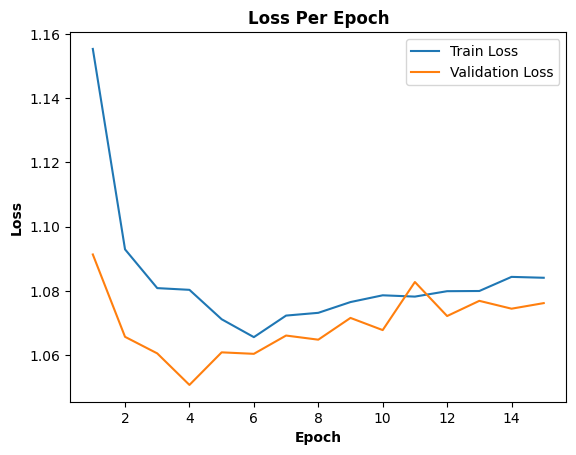

In [43]:
plotComparison(results["train_loss"], "Train Loss",
               results["val_loss"], "Validation Loss",
               "Loss Per Epoch",
               "Loss")

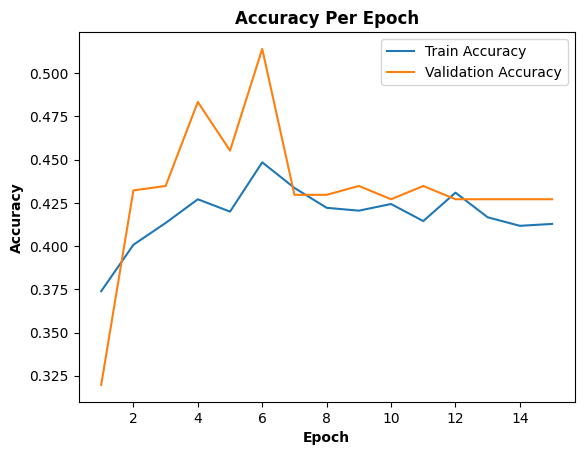

In [44]:
plotComparison(results["train_accuracy"], "Train Accuracy",
               results["val_accuracy"], "Validation Accuracy",
               "Accuracy Per Epoch",
               "Accuracy")

- From the figure, Loss Per Epoch, we observe whether the training loss is decreasing.
- For the figure, Accuracy Per Epoch, we check if both the trainging accuracy and the validation accuracy are increasing. 

## 6.3  Find accuracy on the test data

In [45]:
test_loss, test_accuracy = eval_1Epoch(device=device, 
                                       model=vit,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer_selected)

print(f"Accuracy on test data: {test_accuracy:.3%}")

Accuracy on test data: 43.846%


In [46]:
# Records of the test accuracy with SEED_NO
test_acc_dict = {}
test_acc_dict[SEED_NO] = test_accuracy
print(test_acc_dict)

# Records of the test accuracy
# {seed: accuracy}, optimizer, num_batch, momentum
# {99 : 0.17142857142857143} ADAM 10batch
# {999: 0.4101876675603217}  ADAM 10batch
# {999: 0.4155495978552279}  SGD  10batch momentum=0.2
# {7:   0.376657824933687}   SGD  20batch momentum=0.2
# {10: 0.3793103448275862}   SGD  20batch momentum=0.6
# {999: 0.3103448275862069}  SGD  15batch momentum=0.2
# {100: 0.43846153846153846} SGD  15batch momentum=0.2

{100: 0.43846153846153846}


## 6.4 Make Prediction using our ViT
- Use the trained model to make prediction on a given image.

In [47]:
def predictImage(model: nn.Module, 
                 image_path: str,
                 label_list: list,
                 transform=None, 
                 device: torch.device=device):
    """
    model = vit
    image = "path/file.jpg"
    transform = the same transform as the trainging data
    """
    image = torchvision.io.read_image(str(image_path))
    # output (Tensor[image_channels, image_height, image_width])
    image = image.type(torch.float32)
    image = image / 255.0  # normalized to [0,1]

    if transform:
        image = transform(image)

    # Start prediction using inference_mode()
    model.to(device)
    model.eval()
    with torch.inference_mode():
        # Add 1 dimension to become [num_samples, channel, image_size, image_size]
        img_tensor = image.unsqueeze(dim=0)
        pred_logit = model(img_tensor.to(device))

        # Convert logits to probability distribution
        pred_prob = torch.softmax(pred_logit, dim=1)
        max_prob = pred_prob.max()
                
        # Convert probability to label
        pred_id = torch.argmax(pred_prob, dim=1)
        label_str = label_list[pred_id]
        
        print("Prediction probability for each class:",pred_prob)

    # plot the image
    # need to convert image back to HWC
    plt_img = image.permute(1, 2, 0)
    plt.imshow(plt_img)
    title = f"Prediction: {label_str}\n probility = {max_prob:.2%}"
    plt.title(title)
    plt.axis(False)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction probability for each class: tensor([[0.2958, 0.2551, 0.4492]], device='cuda:0')


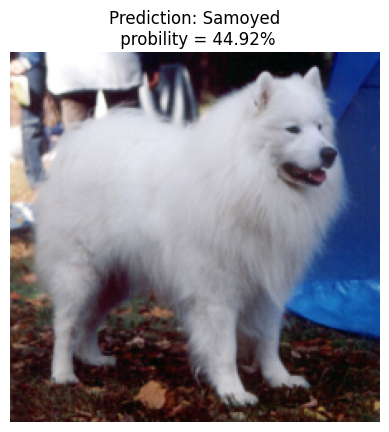

In [49]:
# Download image for prediction test
filename1 = "images/test_samoyed_1.jpeg"
predictImage(model=vit,
             image_path=filename1,
             label_list=breeds,
             transform=transform_original,
             device=device)

## 6.5 Analysis for our Vision Transformer that is implemented from scratch
- Although we have successfully implemented our Vision Transformer mode, the test accuracy of the model remains low.
- Analyzing our training results, it appears that the decreasing trend of the training loss has reached a plateau. And, the accuracy plot does not look promising. From the training/validation plots, it seems like our model is **underfitting**. Our results are far behind those presented in the original paper.
- This discrepancy can be attributed to **the limited size of our dataset for training the model**. Even with data augmentation, our model comprises only about 25 hundred images, whereas the origianl paper leveraged large scale datasets such as **ImageNet-21k** and **JFT-300M**. Unfortunately, our computational resources restrict us from training on these large scale datasets.
- Thus, we need to take advantage of the pretrained model to perform a transfer learning. 

# 7. Transfer Learning
Given our constrained computing resources, adopting a pretrained model becomes essential for conducting transfer learning.

## 7.1 Get the pretrained Vision Transformer 
- We use the pretrained model from **torchvision.models**. You can also find pretrained models on HuggingFace and Torch Image Models (TIMM) library.

In [50]:
# Get the pretrained weights for the Vision Transformer - base
pretrained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup the ViT model with the specified pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 85.5MB/s] 


In [51]:
# When using the pretrained weights, do not need to update weights.
# Freeze the parameters
for param in pretrained_vit.parameters():
    param.requires_grad = False

randomSeed(SEED_NO)
# Only need to train the classifier head
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(breeds)).to(device)
# pretrained_vit

In [52]:
# Use torchinfo to print the summary of the model
summary(model = pretrained_vit,
        input_size = (BATCH_SIZE, CHANNELS, IMG_SIZE, IMG_SIZE), 
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

**Notes**
- While employing pretrained models, we freeze the model parameters, preventing further updates.
- In the pretrained ViT model, only the last linear layer remains trainable. The trainable layer is the MLP Head. We need to train this fully-connecd neural network as a classifier to accurately identify specified classes, such as dog breed 1 or dog breed 2, in the image clasification task.

## 7.2 Create dataloaders for the pretrained ViT
- Because we are going to use a pretrained model from **torchvision.models**, we have to use the specific transform that is adopted in the pretrained model. Then, we prepare our dataset with this specific transform. We ensure that the custom data undergoes the same transformation process as the original training data utilized in the pretrained models.


In [53]:
# The dataset need to use the same transform in the pretrained ViT model
# Get automatic transforms from pretrained ViT weights
transforms_pViT = pretrained_weights.transforms()
print(transforms_pViT)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [54]:
# The dataset need to use the same transform in the pretrained ViT model
dataset_pViT = torchvision.datasets.ImageFolder(dataset_dir, transform=transforms_pViT)
print("The original content of Stanford Dogs Dataset") 
print(f"Number of dog images: {len(dataset_pViT)}")
print(f"Number of dog breeds: {len(dataset_pViT.classes)}")

The original content of Stanford Dogs Dataset
Number of dog images: 521
Number of dog breeds: 3


In [56]:
train_data_pViT, val_data_pViT, test_data_pViT = torch.utils.data.random_split(dataset_pViT, split_ratio)

# Create dataloaders
train_dataloader_pViT = torch.utils.data.DataLoader(train_data_pViT,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

val_dataloader_pViT = torch.utils.data.DataLoader(val_data_pViT,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

test_dataloader_pViT = torch.utils.data.DataLoader(test_data_pViT,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

In [57]:
print("For the pretrained ViT,")
print("\tSize of training data: ", len(train_data_pViT))
print("\tSize of validation data: ", len(val_data_pViT))
print("\tSize of test data: ", len(test_data_pViT))

For the pretrained ViT,
	Size of training data:  365
	Size of validation data:  78
	Size of test data:  78


## 7.3 Training with a pretrained ViT

In [58]:
## Use the pretrained ViT model to train the classifier head
optimizer_Adam_pViT = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

optimizer_SGD_pViT = torch.optim.SGD(params=pretrained_vit.parameters(), 
                                lr=3e-4,    # smaller learing rate for pretrained ViT
                                momentum=0.2,
                                weight_decay=0.3) 
                                
optimizer_pViT = optimizer_SGD_pViT

randomSeed(SEED_NO)
pretrained_vit_results = trainAll(device=device,
                                  model=pretrained_vit,                   # !!!
                                  train_dataloader=train_dataloader_pViT, # !!!
                                  eval_dataloader=val_dataloader_pViT,    # !!!
                                  loss_fn=loss_fn,
                                  optimizer=optimizer_pViT,         # !!!
                                  epochs=10)

 10%|█         | 1/10 [00:25<03:51, 25.77s/it]

Epoch: 1/10, training: loss = 1.0400 	 accuracy = 43.836%
Epoch: 1/10, validation: loss = 1.0630 	 accuracy = 38.107%


 20%|██        | 2/10 [00:51<03:27, 25.89s/it]

Epoch: 2/10, training: loss = 0.9049 	 accuracy = 70.685%
Epoch: 2/10, validation: loss = 0.9703 	 accuracy = 55.499%


 30%|███       | 3/10 [01:17<03:02, 26.04s/it]

Epoch: 3/10, training: loss = 0.7980 	 accuracy = 84.932%
Epoch: 3/10, validation: loss = 0.9001 	 accuracy = 71.100%


 40%|████      | 4/10 [01:44<02:36, 26.12s/it]

Epoch: 4/10, training: loss = 0.7061 	 accuracy = 90.685%
Epoch: 4/10, validation: loss = 0.8312 	 accuracy = 82.097%


 50%|█████     | 5/10 [02:10<02:10, 26.05s/it]

Epoch: 5/10, training: loss = 0.6359 	 accuracy = 93.151%
Epoch: 5/10, validation: loss = 0.7677 	 accuracy = 86.701%


 60%|██████    | 6/10 [02:35<01:43, 25.91s/it]

Epoch: 6/10, training: loss = 0.5701 	 accuracy = 94.521%
Epoch: 6/10, validation: loss = 0.7269 	 accuracy = 90.281%


 70%|███████   | 7/10 [03:01<01:18, 26.00s/it]

Epoch: 7/10, training: loss = 0.5139 	 accuracy = 96.712%
Epoch: 7/10, validation: loss = 0.6739 	 accuracy = 93.095%


 80%|████████  | 8/10 [03:27<00:51, 25.94s/it]

Epoch: 8/10, training: loss = 0.4670 	 accuracy = 97.808%
Epoch: 8/10, validation: loss = 0.6465 	 accuracy = 93.606%


 90%|█████████ | 9/10 [03:54<00:26, 26.08s/it]

Epoch: 9/10, training: loss = 0.4386 	 accuracy = 98.904%
Epoch: 9/10, validation: loss = 0.6181 	 accuracy = 96.164%


100%|██████████| 10/10 [04:20<00:00, 26.04s/it]

Epoch: 10/10, training: loss = 0.3972 	 accuracy = 99.178%
Epoch: 10/10, validation: loss = 0.5845 	 accuracy = 96.675%
Time spent: 4.34 minutes


## 7.4 Plot training results 

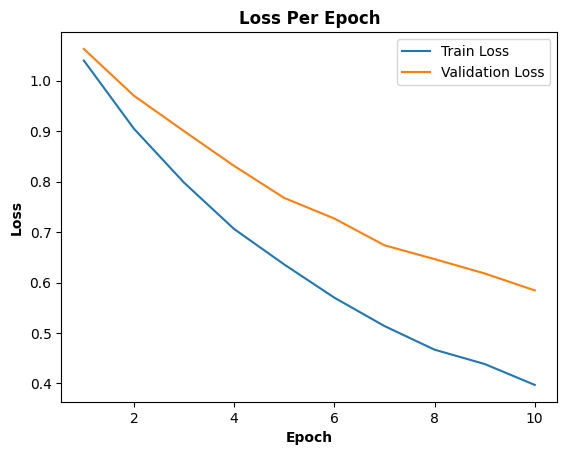

In [59]:
plotComparison(pretrained_vit_results["train_loss"], "Train Loss",
               pretrained_vit_results["val_loss"], "Validation Loss",
               "Loss Per Epoch", "Loss")

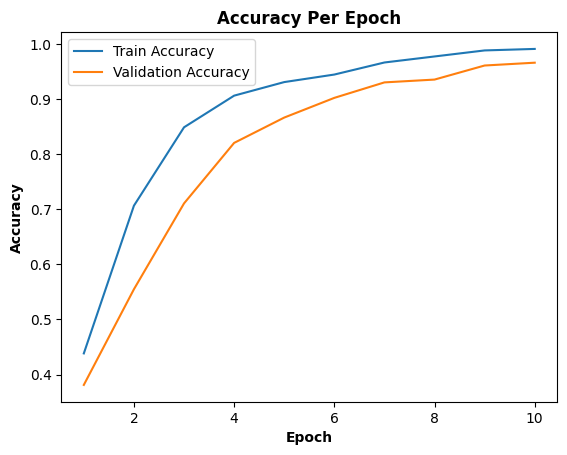

In [60]:
plotComparison(pretrained_vit_results["train_accuracy"], "Train Accuracy",
               pretrained_vit_results["val_accuracy"], "Validation Accuracy",
               "Accuracy Per Epoch",
               "Accuracy")

In [61]:
### Find accuracy on the test data

In [62]:
test_loss_pViT, test_accuracy_pViT = eval_1Epoch(device=device, 
                                                 model=pretrained_vit,
                                                 dataloader=test_dataloader_pViT,
                                                 loss_fn=loss_fn,
                                                 optimizer=optimizer_pViT)

print("Accuracy on test data: {:.3%}", test_accuracy_pViT)

Accuracy on test data: {:.3%} 0.9743589743589743


## 7.4 Make Prediction using the pretrained ViT

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction probability for each class: tensor([[0.1361, 0.1425, 0.7213]], device='cuda:0')


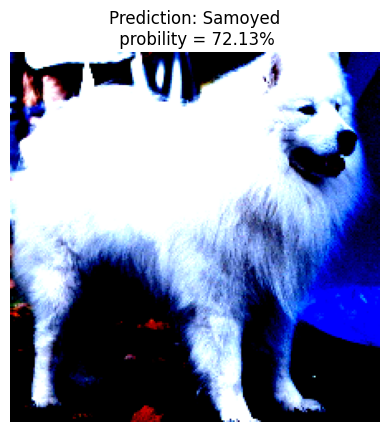

In [63]:
predictImage(model=pretrained_vit,
             image_path=filename1,
             label_list=breeds,
             transform=transforms_pViT,
             device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction probability for each class: tensor([[0.6962, 0.1843, 0.1194]], device='cuda:0')


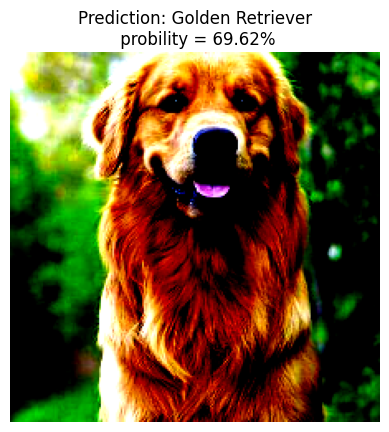

In [64]:
filename2 = "images/test_golden_retriever_1.jpeg"
predictImage(model=pretrained_vit,
             image_path=filename2,
             label_list=breeds,
             transform=transforms_pViT,
             device=device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction probability for each class: tensor([[0.1658, 0.6487, 0.1855]], device='cuda:0')


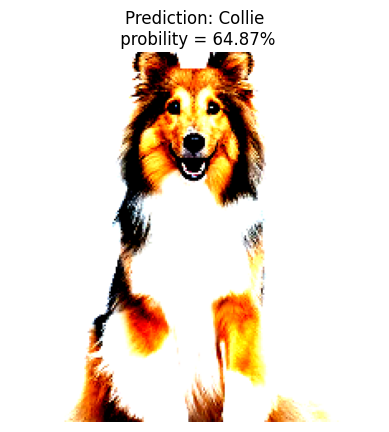

In [65]:
filename3 = "images/test_collie_1.jpeg"
predictImage(model=pretrained_vit,
             image_path=filename3,
             label_list=breeds,
             transform=transforms_pViT,
             device=device)

### Summary
- Examining the training/validation plots, it shows a smaller training loss and high accuracy. 
- When we adopt the pretrained weights and ViT model, the test accuracy for image classification task become precisely accurate. This model perform well even though the size of our training dataset is small. 
    
Finally, with the help of pretrained ViT, we successfully perform image classification for different dog breeds. 

Thank you for checking out this notebook!